In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.utils import check_array, _safe_indexing, sparsefuncs_fast, check_X_y, check_random_state
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.base import clone
from numbers import Integral
from sklearn.svm import SVC
from collections import Counter
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, SMOTENC, SVMSMOTE
import os
# import missingpy as missingpy
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
import pickle
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, roc_auc_score

# Set folder paths for outputs

In [3]:
os.chdir('..') 
REPO_ROOT = Path(os.getcwd())
DATA = Path(REPO_ROOT / 'data')
MODELS = Path(REPO_ROOT / 'model')
REPORTS = Path(REPO_ROOT / 'reports' / 'car')

In [4]:
os.chdir('..')
PATH_1 = Path(os.getcwd())
os.chdir('..')
Path(os.getcwd())

PosixPath('/Users/armandoassembleia/Desktop/Tese/Outlier')

In [5]:
from Mixed_Distances.distMix import distmix
from scipy.spatial.distance import cdist
from Sampling_Methods.Balance import BalanceDataset
from Sampling_Methods.Sampling_Study.auxSamplingStudy import *

In [6]:
os.chdir(PATH_1)
Path(os.getcwd())

PosixPath('/Users/armandoassembleia/Desktop/Tese/Outlier/Sampling_Methods')

# Read the file

In [7]:
df= pd.read_csv(DATA / 'car.csv')

In [8]:
df.columns

Index(['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'target'], dtype='object')

In [9]:
df.shape

(1728, 7)

# The target column has 4 labels

In [10]:
df.target.unique()

array(['unacc', 'acc', 'vgood', 'good'], dtype=object)

#### In order to feed the data to any machine learning method, it's convenient to change strings to numeric values. So, we are going to changethese 4 target labels to values from 0 to 3

In [11]:
df['target'].replace({'unacc': 0, 'acc': 1, 'vgood': 2, 'good': 3},inplace = True)


In [12]:
df.drop_duplicates(inplace=True)

In [13]:
df.isnull().sum()

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
target      0
dtype: int64

In [14]:
df.shape

(1728, 7)

In [15]:
df.columns

Index(['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'target'], dtype='object')

# Create helper functions

In [16]:
## Split the data to be 5-fold cross-validated
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

#randomforest model - hyperparameter tuning using grid search

param_grid = {
'max_depth': [2, 3, 4], 'max_features': [2, 3, 4],
'min_samples_leaf': [2, 3], 'min_samples_split': [3, 4], 'n_estimators': [500]
}# Create a base model
param_grid = {'randomforestclassifier__' + key: param_grid[key] for key in param_grid}

param_grid = {
'max_depth': [2, 4], 'max_features': [2, 4],
'min_samples_leaf': [2, 3], 'min_samples_split': [3, 4], 'n_estimators': [500]
}# Create a base model
param_grid = {'randomforestclassifier__' + key: param_grid[key] for key in param_grid}

In [17]:
print(df.buying.unique())
print(df.maint.unique())
print(df.doors.unique())
print(df.persons.unique())
print(df.lug_boot.unique())
print(df.safety.unique())

['vhigh' 'high' 'med' 'low']
['vhigh' 'high' 'med' 'low']
['2' '3' '4' '5more']
['2' '4' 'more']
['small' 'med' 'big']
['low' 'med' 'high']


In [18]:
Counter(df.target)

Counter({0: 1210, 1: 384, 2: 65, 3: 69})

In [19]:
## Check target label's distribution in the dataset - Class 0 is the majority class
## and there are very few observations for class 2 and 3.
## That's why we are gong to choose class 1 as the minority class for this study

In [20]:
df = df.loc[df['target'].isin([1,0])]

In [21]:
df_feature= df.drop('target',1)
df_target= df[['target']]

In [22]:
df_target.shape

(1594, 1)

In [23]:
df_target.sum(axis=0)

target    384
dtype: int64

In [24]:
df_target.sum(axis=0) / df_target.shape[0]

target    0.240903
dtype: float64

In [25]:
encoded_df = MultiColumnLabelEncoder(columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']).fit_transform(df_feature)


In [26]:
# Split the raw data into train and test set. Split ratio = 75:25

X_train, X_test, y_train, y_test = train_test_split(encoded_df, df_target, test_size=0.25, random_state=12)

In [27]:
for cols in encoded_df:
    print(cols, encoded_df[cols].unique())

buying [3 0 2 1]
maint [3 0 2 1]
doors [0 1 2 3]
persons [0 1 2]
lug_boot [2 1 0]
safety [1 2 0]


In [28]:
Counter(df_target.target)

Counter({0: 1210, 1: 384})

In [29]:
col_list = list(X_train.columns)
X_train.index = pd.RangeIndex(len(X_train.index))
y_train.index = pd.RangeIndex(len(y_train.index))
X_test.index = pd.RangeIndex(len(X_test.index))
y_test.index = pd.RangeIndex(len(y_test.index))

In [30]:
## Apply standard scaler on the features , so that euclidean distance calculation in SMOTE is not biased

#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

In [31]:
X_train = pd.DataFrame(X_train, index=range(X_train.shape[0]),
                          columns=col_list)
X_test = pd.DataFrame(X_test, index=range(X_test.shape[0]),
                          columns=col_list)

In [32]:
X_train

,buying,maint,doors,persons,lug_boot,safety
0,3,1,1,2,2,2
1,2,2,2,1,2,1
2,3,2,3,1,0,2
3,2,1,3,0,0,0
4,2,3,1,1,1,2
...,...,...,...,...,...,...
1190,0,3,0,0,2,1
1191,1,3,1,1,2,1
1192,1,3,0,2,2,1
1193,1,3,1,0,1,1


In [32]:
## Apply the random-forest classifier along with the NEW SMOTE method

filename = (MODELS / 'car_mysmotenc.sav')
samp_pipeline = make_pipeline(MySMOTENC(categorical_features = [0, 1, 2, 3, 4, 5]), 
                              RandomForestClassifier(random_state=42))
# check model performance on different values of hyper-parameters.
grid_search = GridSearchCV(samp_pipeline, param_grid=param_grid, cv=kfold, scoring='balanced_accuracy',
                        return_train_score=True, n_jobs = 1, verbose = 2)
grid_search.fit(X_train, y_train)
best_grid = grid_search.best_estimator_
pickle.dump(best_grid, open(filename, 'wb'))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END randomforestclassifier__max_depth=2, randomforestclassifier__max_features=2, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   0.0s
[CV] END randomforestclassifier__max_depth=2, randomforestclassifier__max_features=2, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   0.0s
[CV] END randomforestclassifier__max_depth=2, randomforestclassifier__max_features=2, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   0.0s
[CV] END randomforestclassifier__max_depth=2, randomforestclassifier__max_features=2, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   

ValueError: Found array with 0 feature(s) (shape=(1195, 0)) while a minimum of 1 is required.

In [ ]:
## Apply the random-forest classifier along with the existing SMOTE method

filename = (MODELS / 'car_smotenc.sav')
samp_pipeline = make_pipeline(SMOTENC(random_state=42, categorical_features = [0, 1, 2, 3, 4, 5]), 
                              RandomForestClassifier(random_state=42))
# check model performance on different values of hyper-parameters.
grid_search = GridSearchCV(samp_pipeline, param_grid=param_grid, cv=kfold, scoring='balanced_accuracy',
                        return_train_score=True, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
best_grid = grid_search.best_estimator_
pickle.dump(best_grid, open(filename, 'wb'))

filename = (MODELS / 'car_smotenc.sav')
loaded_model = pickle.load(open(filename, 'rb'))
threshold = 0.5
print('                RF performance Report')

evaluate(X_train, y_train, threshold)
evaluate(X_test, y_test, threshold)
loaded_model.steps[1][1].feature_importances_

In [33]:
## Apply the random-forest classifier along with the existing SMOTE method

dict_methods = {"gower": {"method": "gower", "weigths_boolean": False, "nbins":3},
                "huang": {"method": "huang", "weigths_boolean": False, "nbins":3},
                "ahmad3": {"method": "ahmad", "weigths_boolean": True, "nbins":3},
                "ahmadMah3": {"method": "ahmad_mahalanobis", "weigths_boolean": True, "nbins":3},
                "ahmadL13": {"method": "ahmad_l1", "weigths_boolean": True, "nbins":3}}   

methods_saved = []

for name, dict_info in dict_methods.items():

    filename = (MODELS / f'car_rsmotenc_{name}.sav')
    samp_pipeline = make_pipeline(BalanceDataset(cat_vars = X_train.columns[[0, 1, 2, 3, 4, 5]], method=dict_info["method"], weigths_boolean = dict_info["weigths_boolean"], nbins=dict_info["nbins"]), 
                                RandomForestClassifier(random_state=42))
    # check model performance on different values of hyper-parameters.
    grid_search = GridSearchCV(samp_pipeline, param_grid=param_grid, cv=kfold, scoring='balanced_accuracy',
                            return_train_score=True, n_jobs = 1, verbose = 2)
    grid_search.fit(X_train, y_train)
    best_grid = grid_search.best_estimator_
    pickle.dump(best_grid, open(filename, 'wb'))

    methods_saved.append(name)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[]
[]
[0, 1, 2, 3, 4, 5]
---------------------------
---------------------------
Binary finished
---------------------------
Cat finished
---------------------------
[]
[]
[0, 1, 2, 3, 4, 5]
[]
[]
[0, 1, 2, 3, 4, 5]
[]
[]
[0, 1, 2, 3, 4, 5]
---------------------------
---------------------------
Binary finished
---------------------------
Cat finished
---------------------------
(956, 6)
(227, 6)
[[0.         0.83333333 0.83333333 ... 1.         0.5        0.5       ]
 [0.83333333 0.         0.83333333 ... 0.66666667 0.66666667 0.83333333]
 [0.83333333 0.83333333 0.         ... 0.83333333 0.66666667 0.66666667]
 ...
 [1.         0.66666667 0.83333333 ... 0.         1.         0.66666667]
 [0.5        0.66666667 0.66666667 ... 1.         0.         0.83333333]
 [0.5        0.83333333 0.66666667 ... 0.66666667 0.83333333 0.        ]]
[[0.83333333 0.66666667 0.5        ... 1.         0.66666667 0.66666667]
 [0.83333333 0.8333333

In [39]:
methods_saved

['gower', 'huang', 'ahmad3', 'ahmad10', 'ahmadMah3', 'ahmadMah10']

In [38]:
## Evaluate SMOTE-ENC performance on train and test set

filename = (MODELS / 'car_mysmotenc.sav')
loaded_model = pickle.load(open(filename, 'rb'))
print('                RF performance Report')

best_threshold = evaluate_best_threshold(X_train, y_train, loaded_model)
print("Best Threshold: ", best_threshold)
evaluate(X_train, y_train, loaded_model, best_threshold)

best_threshold = evaluate_best_threshold(X_test, y_test)
print("Best Threshold: ", best_threshold)
evaluate(X_test, y_test, loaded_model, best_threshold)

loaded_model.steps[1][1].feature_importances_

                RF performance Report
Best Threshold:  0.5
Predicted  False  True
Actual                
0            878    34
1             34   249
              precision    recall  f1-score   support

           0     0.9627    0.9627    0.9627       912
           1     0.8799    0.8799    0.8799       283

    accuracy                         0.9431      1195
   macro avg     0.9213    0.9213    0.9213      1195
weighted avg     0.9431    0.9431    0.9431      1195

Best Threshold:  0.5
Predicted  False  True
Actual                
0            287    11
1             21    80
              precision    recall  f1-score   support

           0     0.9318    0.9631    0.9472       298
           1     0.8791    0.7921    0.8333       101

    accuracy                         0.9198       399
   macro avg     0.9055    0.8776    0.8903       399
weighted avg     0.9185    0.9198    0.9184       399



array([0.06631695, 0.06094901, 0.0117808 , 0.38486172, 0.02959526,
       0.44649626])

In [51]:
## Evaluate SMOTE-ENC performance on train and test set

filename = (MODELS / 'car_rsmotenc_ahmad3.sav')
loaded_model = pickle.load(open(filename, 'rb'))
print('                RF performance Report')

#best_threshold = evaluate_best_threshold(X_train, y_train, loaded_model, "f1Score1")
#print("Best Threshold: ", best_threshold)
#evaluate(X_train, y_train, loaded_model, best_threshold)

best_threshold = evaluate_best_threshold(X_test, y_test, loaded_model, "f1ScoreRecallIR")
print("Best Threshold: ", best_threshold)
evaluate(X_test, y_test, loaded_model, best_threshold)

loaded_model.steps[1][1].feature_importances_

                RF performance Report
Best Threshold:  0.4
Confusion Matrix : 
 [[101  85]
 [  0 213]]
Accuracy :  0.787
F1-Score IR :  0.737
F1-Score Recall IR :  0.908
Class 1
Precision :  0.543
Sensitivity :  1.0
F1-Score :  0.704
Class 0
Precision :  1.0
Sensitivity :  0.715
F1-Score :  0.834


array([0.05547156, 0.0623919 , 0.02091699, 0.1372449 , 0.04843761,
       0.67553705])

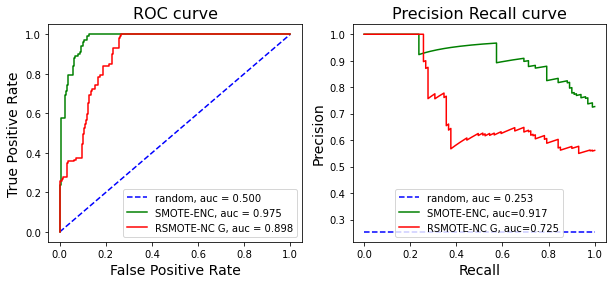

In [35]:
##Create ROC-AUC and PR-AUC curve

dict_models = {"SMOTE-ENC": MODELS / 'car_mysmotenc.sav',
                "RSMOTE-NC G": MODELS / 'car_rsmotenc_ahmadL110.sav'}

#generate_curves(dict_models, X_test, y_test,save = REPORTS / "car_roc_prc.jpeg")
generate_curves(dict_models, X_test, y_test)

<Figure size 720x720 with 0 Axes>

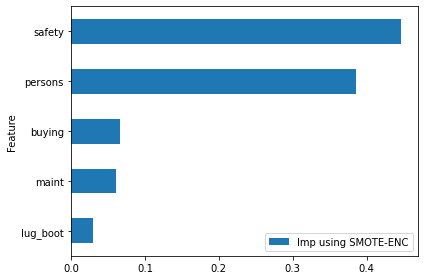

In [34]:
## Find out top 5 most important features using our new SMOTE method

filename = (MODELS / 'car_mysmotenc.sav')
loaded_model = pickle.load(open(filename, 'rb'))
var_imp = (pd.Series(loaded_model.steps[1][1].feature_importances_, index=X_train.columns).nlargest(5))
var_imp_df = var_imp.reset_index()
var_imp_df.columns = ['Feature', 'Imp using SMOTE-ENC']
var_imp_df.set_index('Feature', inplace=True)

plt.figure(figsize=(10, 10))
rcParams.update({'figure.autolayout': True})
var_imp_df.plot(kind='barh').invert_yaxis()
plt.savefig(REPORTS / 'car_mysmote.jpeg', bbox_inches='tight')

<Figure size 720x720 with 0 Axes>

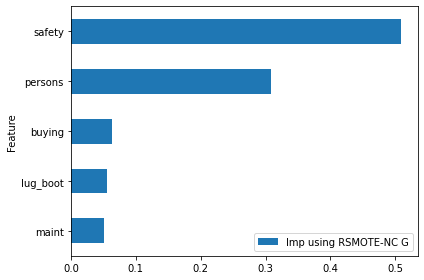

In [36]:
## Find out top 5 most important features using our RSMOTE-NC G method

filename = (MODELS / 'car_rsmotenc_gower.sav')
loaded_model = pickle.load(open(filename, 'rb'))
var_imp = (pd.Series(loaded_model.steps[1][1].feature_importances_, index=X_train.columns).nlargest(5))
var_imp_df = var_imp.reset_index()
var_imp_df.columns = ['Feature', 'Imp using RSMOTE-NC G']
var_imp_df.set_index('Feature', inplace=True)

plt.figure(figsize=(10, 10))
rcParams.update({'figure.autolayout': True})
var_imp_df.plot(kind='barh').invert_yaxis()
plt.savefig(REPORTS / 'car_rsmotenc_gower.jpeg', bbox_inches='tight')

In [29]:
idnum = []
idbin = []
idcat = [0,1,2,3,4,5]

data = encoded_df.to_numpy()

distance_matrices = {"Euclidean": cdist(data.astype(np.float16),data.astype(np.float16)),
                    "Gower" : distmix(data, method = "gower", weigths_boolean = False, nbins=0, idnum = idnum, idbin = idbin, idcat = idcat ),
                    "Huang" : distmix(data, method = "huang", weigths_boolean = False, nbins=0, idnum = idnum, idbin = idbin, idcat = idcat ),
                    "Ahmad - 3": distmix(data, method = "ahmad", weigths_boolean = True, nbins=3, idnum = idnum, idbin = idbin, idcat = idcat ),
                    "Ahmad - 10": distmix(data, method = "ahmad", weigths_boolean = True, nbins=10, idnum = idnum, idbin = idbin, idcat = idcat ),
                    "Ahmad Mah - 3" : distmix(data, method = "ahmad_mahalanobis", weigths_boolean = True, nbins=3, idnum = idnum, idbin = idbin, idcat = idcat ),
                    "Ahmad Mah - 10" : distmix(data, method = "ahmad_mahalanobis", weigths_boolean = True, nbins=10, idnum = idnum, idbin = idbin, idcat = idcat )}

[]
[]
[0, 1, 2, 3, 4, 5]
---------------------------
---------------------------
Binary finished
---------------------------
Cat finished
---------------------------
[]
[]
[0, 1, 2, 3, 4, 5]
---------------------------
---------------------------
Binary finished
---------------------------
Cat finished
---------------------------
[]
[]
[0, 1, 2, 3, 4, 5]
---------------------------
---------------------------
Binary finished
---------------------------
Calculating coocccur...
Same DataFrame
Cooccur time:  2.754657030105591
Cat finished
---------------------------
[]
[]
[0, 1, 2, 3, 4, 5]
---------------------------
---------------------------
Binary finished
---------------------------
Calculating coocccur...
Same DataFrame
Cooccur time:  2.766071081161499
Cat finished
---------------------------
[]
[]
[0, 1, 2, 3, 4, 5]
---------------------------
---------------------------
Binary finished
---------------------------
Calculating coocccur...
Same DataFrame
Cooccur time:  2.74644565582

In [30]:
np.sum(df_target)

target    384
dtype: int64

0
RangeIndex(start=0, stop=1594, step=1)
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1708, 1709, 1710, 1711, 1713, 1716, 1719, 1720, 1722, 1725],
           dtype='int64', length=1594)
0
RangeIndex(start=0, stop=1594, step=1)
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1708, 1709, 1710, 1711, 1713, 1716, 1719, 1720, 1722, 1725],
           dtype='int64', length=1594)
0
RangeIndex(start=0, stop=1594, step=1)
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1708, 1709, 1710, 1711, 1713, 1716, 1719, 1720, 1722, 1725],
           dtype='int64', length=1594)
0
RangeIndex(start=0, stop=1594, step=1)
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1708, 1709, 1710, 1711, 1713, 1716, 1719, 1720, 1722, 1725],
           dtype='int64', length=1594)
0
RangeIndex(start=0, stop=1594, ste

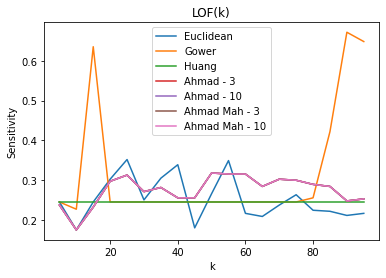

0
RangeIndex(start=0, stop=1594, step=1)
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1708, 1709, 1710, 1711, 1713, 1716, 1719, 1720, 1722, 1725],
           dtype='int64', length=1594)
0
RangeIndex(start=0, stop=1594, step=1)
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1708, 1709, 1710, 1711, 1713, 1716, 1719, 1720, 1722, 1725],
           dtype='int64', length=1594)
0
RangeIndex(start=0, stop=1594, step=1)
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1708, 1709, 1710, 1711, 1713, 1716, 1719, 1720, 1722, 1725],
           dtype='int64', length=1594)
0
RangeIndex(start=0, stop=1594, step=1)
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1708, 1709, 1710, 1711, 1713, 1716, 1719, 1720, 1722, 1725],
           dtype='int64', length=1594)
0
RangeIndex(start=0, stop=1594, ste

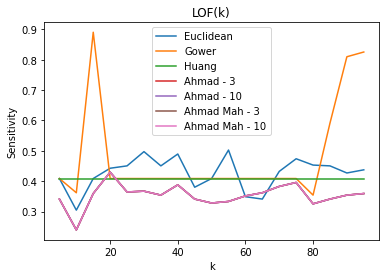

0
RangeIndex(start=0, stop=1594, step=1)
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1708, 1709, 1710, 1711, 1713, 1716, 1719, 1720, 1722, 1725],
           dtype='int64', length=1594)
0
RangeIndex(start=0, stop=1594, step=1)
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1708, 1709, 1710, 1711, 1713, 1716, 1719, 1720, 1722, 1725],
           dtype='int64', length=1594)
0
RangeIndex(start=0, stop=1594, step=1)
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1708, 1709, 1710, 1711, 1713, 1716, 1719, 1720, 1722, 1725],
           dtype='int64', length=1594)
0
RangeIndex(start=0, stop=1594, step=1)
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1708, 1709, 1710, 1711, 1713, 1716, 1719, 1720, 1722, 1725],
           dtype='int64', length=1594)
0
RangeIndex(start=0, stop=1594, ste

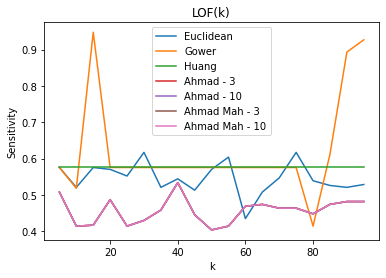

In [31]:
outlier_prevelance = 384
index = encoded_df.index
neigbs = list(range(5,100,5))
metric = "Sensitivity"

test_distances(distance_matrices, df_target, index, neigbs, outlier_prevelance, metric, save = REPORTS / "car_distances100.jpeg")
test_distances(distance_matrices, df_target, index, neigbs, int(outlier_prevelance*1.5), metric, save = REPORTS / "car_distances150.jpeg")
test_distances(distance_matrices, df_target, index, neigbs, outlier_prevelance*2, metric, save = REPORTS / "car_distances200.jpeg")